In [1]:
#libraries and main functions
import skimage
import numpy as np
import czifile
from czifile import CziFile
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation
import numpy as np
from skimage.measure import regionprops
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.measure import label, regionprops
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.filters import try_all_threshold
import czifile as czi
import pandas as pd
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage import exposure
from skimage import morphology
from skimage.measure import label
from skimage.morphology import remove_small_objects
from skimage.morphology import binary_dilation, disk
from os import listdir
from os.path import isfile, join
from cellpose import io, models, plot
model = models.Cellpose(model_type='cyto')

import cv2

In [2]:
def analyze_image(image_path, basename):
    # function for determining circularity
    def is_circular(contour, threshold=0.86):
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                    return False
            circularity = 4 * np.pi * (area / (perimeter * perimeter))
            return circularity > threshold

    # Jiya's function for determining whether an inclusion has circular holes or not (swiss cheese or not)
    # looks like it runs for each individual function
    def has_circular_holes(mask, circularity_threshold=0.65):
            # Ensure the mask is of type np.uint8
            mask = mask.astype(np.uint8)

            # Find contours and hierarchy without thresholding the mask
            contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
            
            # If hierarchy is None, no contours were found
            if hierarchy is None:
                    return False
            # print(len(contours))
            # Iterate over the contours and hierarchy
            for i in range(len(contours)):
                    # If a contour has a parent (i.e., hierarchy[0][i][3] != -1), it is a hole
                    if hierarchy[0][i][3] != -1:
                            if is_circular(contours[i], circularity_threshold):
                                    return True

            return False
    
    def calculate_circularity(area, perimeter):
        circularity = (4 * np.pi * area) / (perimeter**2)
        return circularity

    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)
    red_channel = image_squeezed[0,:,:]
    green_channel = image_squeezed[1,:,:]
    masks, flows, styles, diams = model.eval(green_channel, diameter=320, channels = [0,0])
    labeled_cells = label(masks)

    cell_counter = []
    cell_size = []
    num_inclusions = []
    avg_inclusion_area = []
    num_lipids = []
    avg_lipid_area = []
    cell_num = 0

    count_solid_inc = 0
    count_hollow_inc = 0
    count_sc_inc = 0

    intersection_areas = []
    total_lipid_areas = []
    total_inc_areas = []

    individual_ld_areas = []
    clumped_ld_areas = []
    num_individual_lds = 0
    num_clumped_lds = 0

    print(basename)


    for i, cell in enumerate(regionprops(labeled_cells)):
        mask = labeled_cells == cell.label

        cell_props = regionprops(label(mask))
        if cell_props[0].area < 1000:
            continue
        else:
            cell_num += 1

        applied_mask = gaussian(green_channel) * mask
        mean_cell = np.mean(applied_mask[mask > 0])

        #print(mean_cell)

        if mean_cell > 0.6:
            threshold = 0.675
        else:
            threshold = 0.325
        inclusions = applied_mask > threshold
        inclusions_labeled = label(inclusions)
        
        lipids_cell = mask * gaussian(red_channel)
        lipids_thresholded = lipids_cell > 0.05
        labeled_lipids = label(lipids_thresholded)
        lipid_areas = [lipid.area for lipid in regionprops(labeled_lipids)]

        #inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10]
        inclusion_areas = []

        #print(inclusion_areas)

        if len(inclusion_areas) > 30: #usually, this means the threshold was bad, so I just exclude these cells
            continue
        
        inclusion_props = [inclusion for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10]
        
        #print(f'inclusion_props is len {len(inclusion_props)}')
        
        for inc_prop in inclusion_props:
            if inc_prop.area > 10:
                inclusion_areas.append(inc_prop.area)
                minr, minc, maxr, maxc = inc_prop.bbox
                region_cropped = inclusions[minr:maxr, minc:maxc]
     
                # fill small holes of two pixesl or less, often seen in very small inclusion
                #region_cropped_filled = skimage.morphology.remove_small_holes(region_cropped, area_threshold=2)

                if has_circular_holes(region_cropped):
                    # look for intersection of lipid mask with inclusion mask
                    intersection = np.logical_and(inc_prop, lipids_thresholded)

                    if np.count_nonzero(intersection) > 0:
                        count_sc_inc += 1
                    else:
                        count_hollow_inc += 1
                else:
                    count_solid_inc += 1

        # iterate over lipid droplets, find if it is individual, and add to list if it is
        for lipid_prop in [lipid_droplet for lipid_droplet in regionprops(labeled_lipids) if lipid_droplet.area > 10]:
             # find circularity
             circularity_index = calculate_circularity(lipid_prop.area, lipid_prop.perimeter)
             # based on cutoff of 0.65, it is classified as individual or clumped and added to appropriate list
             if circularity_index > 0.65:
                  individual_ld_areas.append(lipid_prop.area)
                  num_individual_lds = num_individual_lds + 1
             else:
                  clumped_ld_areas.append(lipid_prop.area)
                  num_clumped_lds = num_clumped_lds + 1

        # take the intersection mask
        intersection_mask_lipids_inclusions = np.logical_and(inclusions, lipids_thresholded)

        intersection_area = np.count_nonzero(intersection_mask_lipids_inclusions)
        
        intersection_areas.append(intersection_area)
        total_lipid_areas.append(sum(lipid_areas))
        total_inc_areas.append(sum(inclusion_areas))
        #print(total_inc_areas)
        cell_counter.append(cell_num)
        cell_size.append(cell.area)
        num_inclusions.append(len(inclusion_areas))
        if len(inclusion_areas) > 0:       
            avg_inclusion_area.append(np.mean(inclusion_areas))        
        num_lipids.append(len(lipid_areas))
        if len(lipid_areas) > 0:
            avg_lipid_area.append(np.mean(lipid_areas))


        fig, axes = plt.subplots(2, 3, figsize=(15, 9))
        # Plot each frame
        axes[0, 0].imshow(red_channel)
        axes[0, 0].set_title(f'red channel {basename}')
        axes[0, 0].axis('off')

        axes[1,0].imshow(lipids_thresholded)
        axes[1,0].set_title('thresholded lipids (red)')
        axes[1,0].axis('off')

        axes[0, 1].imshow(green_channel)
        axes[0, 1].set_title('green channel')
        axes[0, 1].axis('off')

        axes[1,1].imshow(inclusions)
        axes[1,1].set_title('thresholded inclusions (green)')
        axes[1,1].axis('off')

        axes[0,2].imshow(labeled_cells)
        axes[0,2].set_title('All cell mask')
        axes[0,2].axis('off')

        axes[1,2].imshow(applied_mask)
        axes[1,2].set_title('single cell')
        axes[1,2].axis('off')

        plt.tight_layout()
        plt.show()

    if sum(total_lipid_areas) > 0:
         sa_over_lipids = (sum(intersection_areas) / sum(total_lipid_areas)) * 100
    else:
         sa_over_lipids = None

    if sum(total_inc_areas) > 0:
         sa_over_inc = (sum(intersection_areas) / sum(total_inc_areas)) * 100
    else:
         sa_over_inc = None
         

    df = pd.DataFrame(
          {"filename" : basename,
           "number_of_cells" : max(cell_counter),
            "average_cell_size" : np.mean(cell_size),
            "number_of_inclusions" : sum(num_inclusions),
            "avg_inclusion_size" : np.mean(avg_inclusion_area),
            "number_of_lipids" : sum(num_lipids),
            "avg_lipid_size" : np.mean(avg_lipid_area),
            "percent_SA_lipids_overlap_lip" : sa_over_lipids,
            "percent_SA_lipids_overlap_inc" : sa_over_inc,
            "num_solid_inclusions" : count_solid_inc,
            "num_hollow_inclusions" : count_hollow_inc,
            "num_swiss_cheese_inclusions" : count_sc_inc,
            "num_individual_lds" : num_individual_lds,
            "avg_size_individual_ld" : np.mean(individual_ld_areas), 
            "num_clumped_lds" : num_clumped_lds,
            "avg_size_clumped_lds" : np.mean(clumped_ld_areas)}, index=[0],

    )

    df['percent_solid_inclusions'] = (df['num_solid_inclusions'] / df['number_of_inclusions']) * 100
    df['percent_hollow_inclusions'] = (df['num_hollow_inclusions'] / df['number_of_inclusions']) * 100
    df['percent_swiss_cheese_inclusions'] = (df['num_swiss_cheese_inclusions'] / df['number_of_inclusions']) * 100
    
    return df

noOA_Hex0.5_01


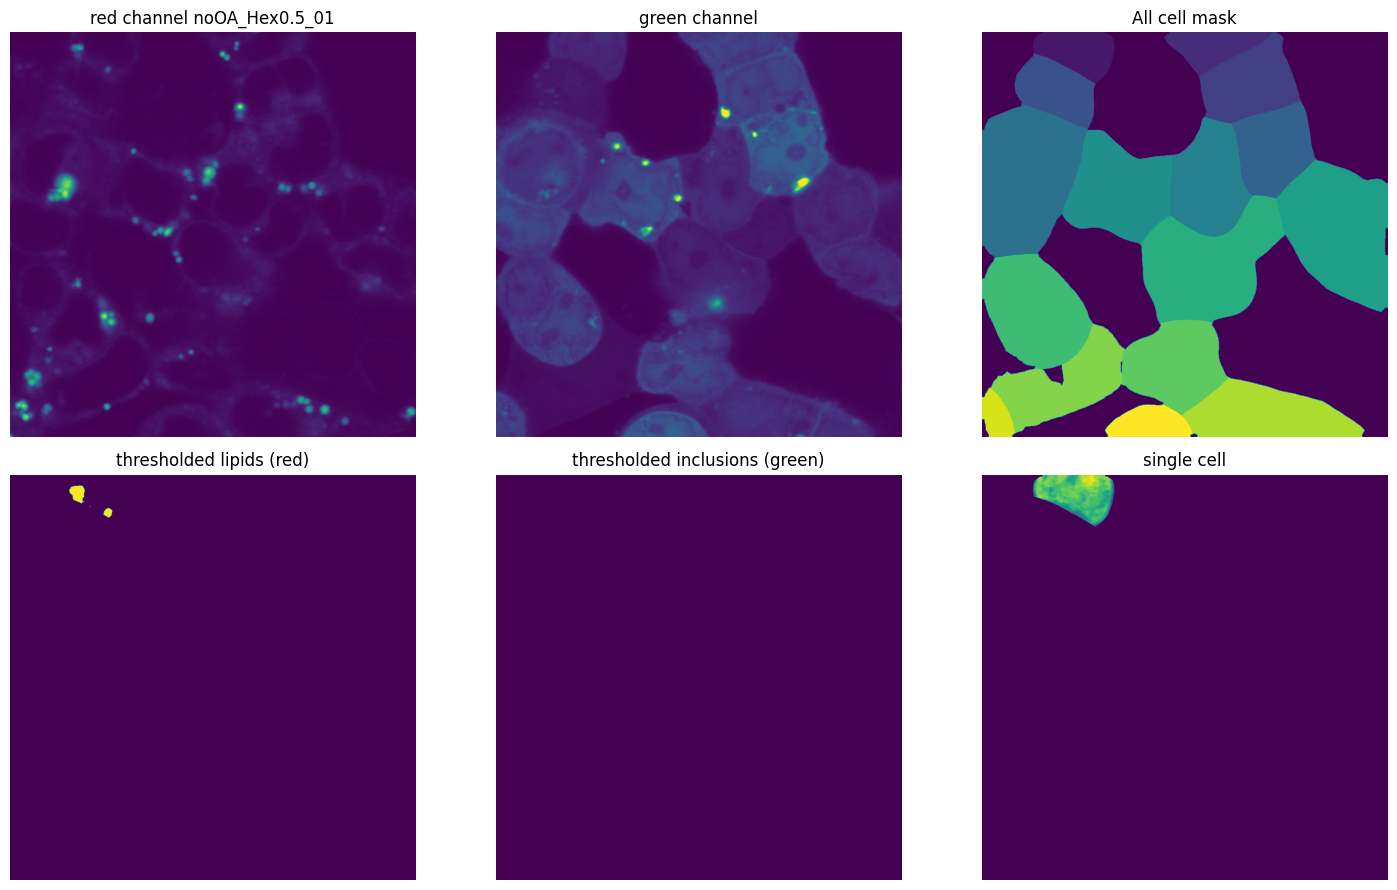

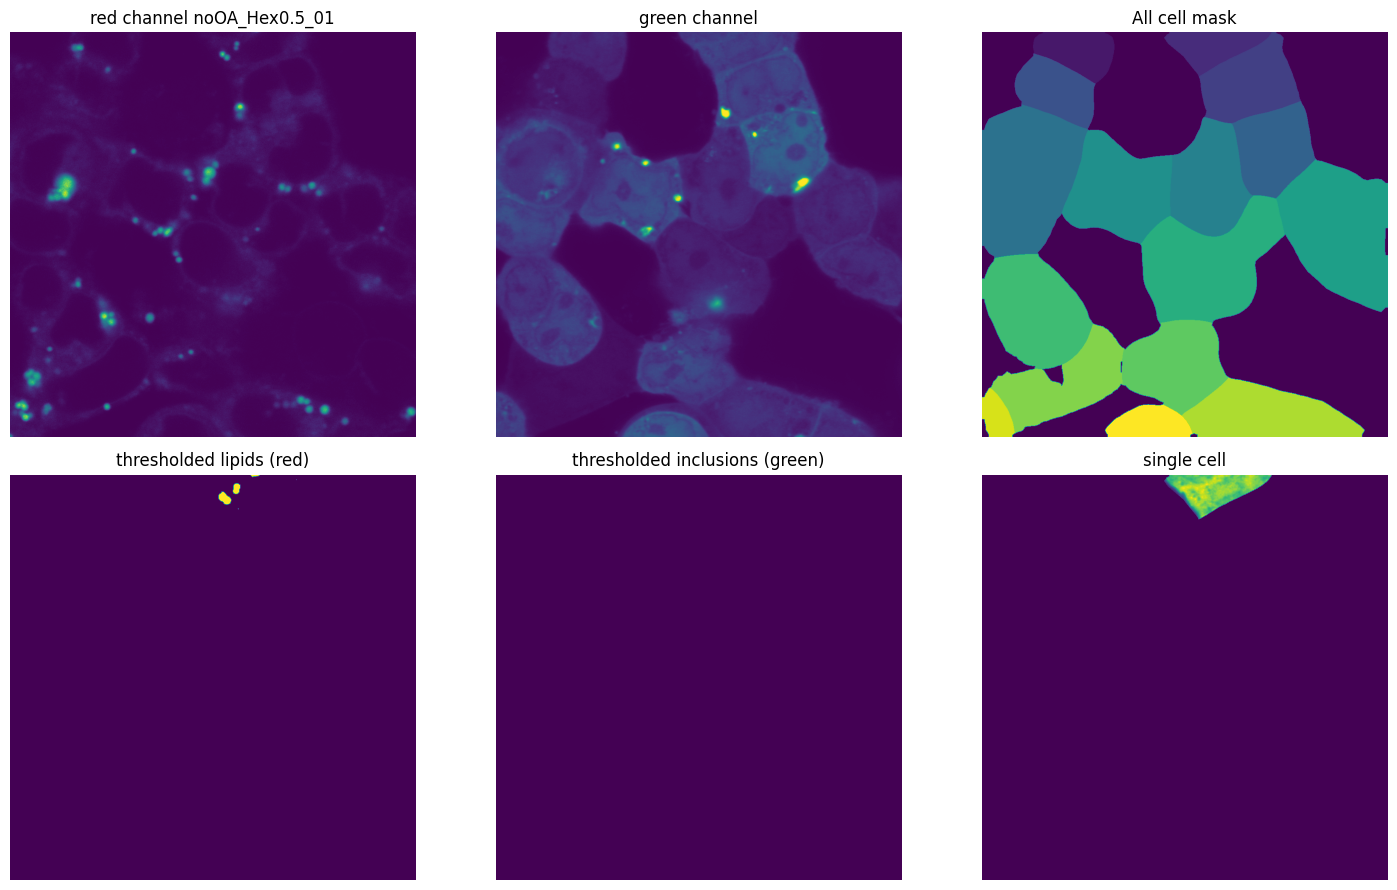

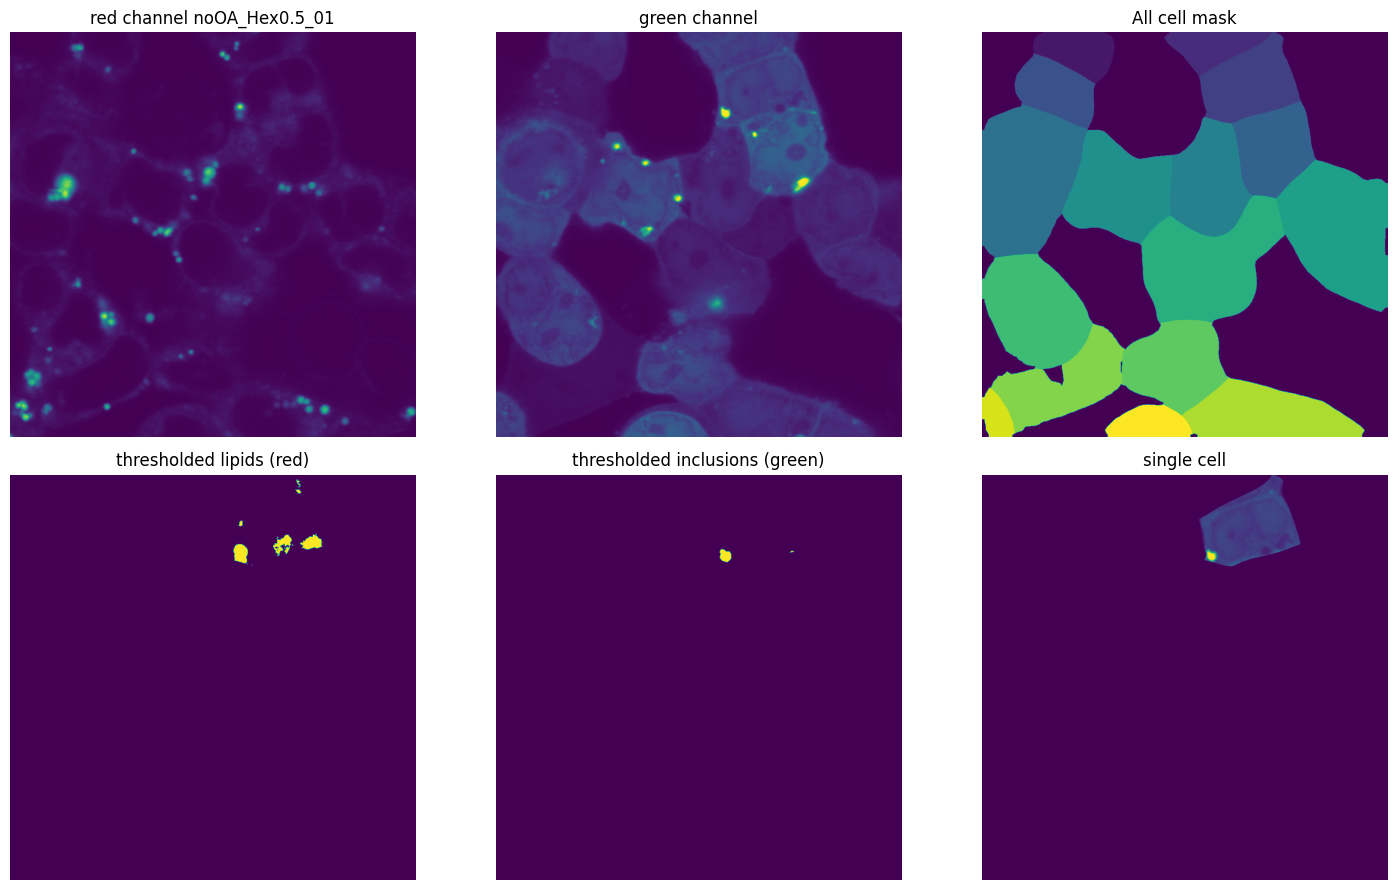

KeyboardInterrupt: 

In [4]:
all_data = []

folder_path = "lipids_hex_oa_images"
for well_image in os.listdir(folder_path):
    if well_image.lower().endswith(".czi"):  # Filters for CZI files
        well_image_path = os.path.join(folder_path, well_image)
        well_image_base_name = os.path.basename(well_image)[:-4]

        df = analyze_image(well_image_path, well_image_base_name)
        #all_data.append(df)

display(df)
